In [1]:
%matplotlib inline
from base import fetch_data, B2B, Forward
from common import log_files, data_path
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import pickle
import time
import submitit
import os.path as op

In [2]:
def run(subject, model_name, window=1, overwrite=False):
    """Loop Granger score for each time sample independently"""
    start = time.time()
    print(start)
    
    # Paths
    preproc_path = op.join(data_path, '..', 'jrr', '%s-preproc.pkl' % subject.subject)
    save_path = op.join(data_path, '..', 'jrr', '%s-%s-%i.pkl' % (subject.subject, model_name, window))
    
    # Don't compute if already exists
    if op.isfile(save_path) and not overwrite:
        with open(save_path, 'rb') as f:
            return pickle.load(f)
    
    # Load and preprocess data
    if op.isfile(preproc_path) and not overwrite:
        with open(preproc_path, 'rb') as f:
            meg, times, features, names = pickle.load(f)
    else:
        meg, times, features, names = fetch_data(subject)
        with open(preproc_path, 'wb') as f:
            pickle.dump([meg, times, features, names], f)

    features = features[:, :12]
    
    # Prepare model
    models = dict(B2B=B2B(knockout=True),
                  Forward=Forward(knockout=True))
    model = models[model_name]
    cv = KFold(5, shuffle=True)
    n_features = features.shape[1]
    _, n_channels, n_times = meg.shape

    # Depending on the model, we may make predictions on different Y dimensions
    n_y = tuple() if model_name == 'B2B' else tuple([n_channels*window, ])

    # Loop across times
    H = np.zeros((cv.n_splits, n_times, n_features, *n_y))
    H_r = np.zeros((cv.n_splits, n_times, n_features, *n_y))
    K_r = np.zeros((cv.n_splits, n_times, n_features, *n_y))

    for t in trange(n_times-window):
        for split, (train, test) in enumerate(cv.split(features)):
            Y = meg[:, :, t:t+window].reshape(len(meg), -1)
            
            # Fit model
            model.fit(X=features[train],
                      Y=Y[train])
            # Retrieve coefficients
            H_ = np.diag(model.H_) if model_name == 'B2B' else model.H_.T
            H[split, t] = H_
            # Compute standard scores
            H_r[split, t] = model.score(X=features[test],
                                        Y=Y[test])
            # Compute knock out scores
            K_r[split, t] = model.score_knockout(X=features[test],
                                                 Y=Y[test])

    # Mean across splits
    H = H.mean(0)
    H_r = H_r.mean(0)
    K_r = K_r.mean(0)
    
    # Save
    print('save')
    with open(save_path, 'wb') as f:
        pickle.dump([H, H_r, K_r, times, features], f)
    
    
    print(time.time() - start)
    
    return H, H_r, K_r, times, features

In [6]:
subject_info = log_files.iloc[0]
H, H_r, K_r, times, features = run(subject_info, 'B2B', window=20, overwrite=False)

1564979266.013649


  0%|          | 0/251 [00:00<?, ?it/s]

0


  0%|          | 1/251 [00:04<16:44,  4.02s/it]

1


  1%|          | 2/251 [00:08<17:10,  4.14s/it]

2


  1%|          | 3/251 [00:12<17:04,  4.13s/it]

3


  2%|▏         | 4/251 [00:16<16:26,  3.99s/it]

4


  2%|▏         | 5/251 [00:20<16:50,  4.11s/it]

5


  2%|▏         | 6/251 [00:24<16:39,  4.08s/it]

6


  3%|▎         | 7/251 [00:28<16:44,  4.12s/it]

7


  3%|▎         | 8/251 [00:32<16:03,  3.96s/it]

8


  4%|▎         | 9/251 [00:36<15:59,  3.96s/it]

9


  4%|▍         | 10/251 [00:39<15:28,  3.85s/it]

10


  4%|▍         | 11/251 [00:43<15:12,  3.80s/it]

11


  5%|▍         | 12/251 [00:47<15:32,  3.90s/it]

12


  5%|▌         | 13/251 [00:51<15:06,  3.81s/it]

13


  6%|▌         | 14/251 [00:54<14:47,  3.74s/it]

14


  6%|▌         | 15/251 [00:59<15:16,  3.88s/it]

15


  6%|▋         | 16/251 [01:02<14:58,  3.82s/it]

16


  7%|▋         | 17/251 [01:06<14:53,  3.82s/it]

17


  7%|▋         | 18/251 [01:10<15:09,  3.90s/it]

18


  8%|▊         | 19/251 [01:14<14:43,  3.81s/it]

19


  8%|▊         | 20/251 [01:18<14:29,  3.76s/it]

20


  8%|▊         | 21/251 [01:22<14:44,  3.85s/it]

21


  9%|▉         | 22/251 [01:25<14:32,  3.81s/it]

22


  9%|▉         | 23/251 [01:29<14:18,  3.76s/it]

23


 10%|▉         | 24/251 [01:33<14:39,  3.87s/it]

24


 10%|▉         | 25/251 [01:37<14:32,  3.86s/it]

25


 10%|█         | 26/251 [01:41<14:43,  3.93s/it]

26


 11%|█         | 27/251 [01:45<14:42,  3.94s/it]

27


 11%|█         | 28/251 [01:49<14:40,  3.95s/it]

28


 12%|█▏        | 29/251 [01:53<14:21,  3.88s/it]

29


 12%|█▏        | 30/251 [01:56<14:12,  3.86s/it]

30


 12%|█▏        | 31/251 [02:00<14:06,  3.85s/it]

31


 13%|█▎        | 32/251 [02:04<13:54,  3.81s/it]

32


 13%|█▎        | 33/251 [02:08<14:11,  3.90s/it]

33


 14%|█▎        | 34/251 [02:12<14:15,  3.94s/it]

34


 14%|█▍        | 35/251 [02:16<13:59,  3.89s/it]

35


 14%|█▍        | 36/251 [02:20<13:51,  3.87s/it]

36


 15%|█▍        | 37/251 [02:23<13:24,  3.76s/it]

37


 15%|█▌        | 38/251 [02:27<13:33,  3.82s/it]

38


 16%|█▌        | 39/251 [02:31<13:22,  3.79s/it]

39


 16%|█▌        | 40/251 [02:35<13:20,  3.79s/it]

40


 16%|█▋        | 41/251 [02:38<13:09,  3.76s/it]

41


 17%|█▋        | 42/251 [02:43<13:32,  3.89s/it]

42


 17%|█▋        | 43/251 [02:46<13:11,  3.81s/it]

43


 18%|█▊        | 44/251 [02:50<12:54,  3.74s/it]

44


 18%|█▊        | 45/251 [02:54<13:21,  3.89s/it]

45


 18%|█▊        | 46/251 [02:58<13:00,  3.81s/it]

46


 19%|█▊        | 47/251 [03:01<12:39,  3.72s/it]

47


 19%|█▉        | 48/251 [03:05<12:23,  3.66s/it]

48


 20%|█▉        | 49/251 [03:09<12:47,  3.80s/it]

49


 20%|█▉        | 50/251 [03:12<12:30,  3.74s/it]

50


 20%|██        | 51/251 [03:16<12:16,  3.68s/it]

51


 21%|██        | 52/251 [03:20<12:09,  3.67s/it]

52


 21%|██        | 53/251 [03:24<12:35,  3.82s/it]

53


 22%|██▏       | 54/251 [03:28<12:32,  3.82s/it]

54


 22%|██▏       | 55/251 [03:31<12:11,  3.73s/it]

55


 22%|██▏       | 56/251 [03:35<12:11,  3.75s/it]

56


 23%|██▎       | 57/251 [03:39<12:05,  3.74s/it]

57


 23%|██▎       | 58/251 [03:42<11:54,  3.70s/it]

58


 24%|██▎       | 59/251 [03:46<12:16,  3.84s/it]

59


 24%|██▍       | 60/251 [03:50<11:54,  3.74s/it]

60


 24%|██▍       | 61/251 [03:53<11:38,  3.67s/it]

61


 25%|██▍       | 62/251 [03:57<11:56,  3.79s/it]

62


 25%|██▌       | 63/251 [04:01<11:39,  3.72s/it]

63


 25%|██▌       | 64/251 [04:05<11:31,  3.70s/it]

64


 26%|██▌       | 65/251 [04:10<12:34,  4.06s/it]

65


 26%|██▋       | 66/251 [04:14<12:26,  4.04s/it]

66


 27%|██▋       | 67/251 [04:17<12:05,  3.94s/it]

67


 27%|██▋       | 68/251 [04:22<12:21,  4.05s/it]

68


 27%|██▋       | 69/251 [04:25<12:04,  3.98s/it]

69


 28%|██▊       | 70/251 [04:30<12:06,  4.01s/it]

70


 28%|██▊       | 71/251 [04:34<12:11,  4.06s/it]

71


 29%|██▊       | 72/251 [04:38<12:13,  4.10s/it]

72


 29%|██▉       | 73/251 [04:42<12:02,  4.06s/it]

73


 29%|██▉       | 74/251 [04:46<11:49,  4.01s/it]

74


 30%|██▉       | 75/251 [04:50<11:44,  4.00s/it]

75


 30%|███       | 76/251 [04:54<11:43,  4.02s/it]

76


 31%|███       | 77/251 [04:57<11:21,  3.91s/it]

77


 31%|███       | 78/251 [05:01<11:22,  3.95s/it]

78


 31%|███▏      | 79/251 [05:05<11:16,  3.93s/it]

79


 32%|███▏      | 80/251 [05:10<11:33,  4.05s/it]

80


 32%|███▏      | 81/251 [05:14<11:17,  3.98s/it]

81


 33%|███▎      | 82/251 [05:17<11:01,  3.91s/it]

82


 33%|███▎      | 83/251 [05:21<10:40,  3.81s/it]

83


 33%|███▎      | 84/251 [05:25<10:30,  3.78s/it]

84


 34%|███▍      | 85/251 [05:28<10:15,  3.71s/it]

85


 34%|███▍      | 86/251 [05:32<10:38,  3.87s/it]

86


 35%|███▍      | 87/251 [05:36<10:41,  3.91s/it]

87


 35%|███▌      | 88/251 [05:40<10:41,  3.93s/it]

88


 35%|███▌      | 89/251 [05:44<10:31,  3.90s/it]

89


 36%|███▌      | 90/251 [05:48<10:18,  3.84s/it]

90


 36%|███▋      | 91/251 [05:52<10:12,  3.83s/it]

91


 37%|███▋      | 92/251 [05:56<10:10,  3.84s/it]

92


 37%|███▋      | 93/251 [06:00<10:17,  3.91s/it]

93


 37%|███▋      | 94/251 [06:04<10:17,  3.94s/it]

94


 38%|███▊      | 95/251 [06:07<09:54,  3.81s/it]

95


 38%|███▊      | 96/251 [06:11<09:50,  3.81s/it]

96


 39%|███▊      | 97/251 [06:15<09:41,  3.78s/it]

97


 39%|███▉      | 98/251 [06:18<09:30,  3.73s/it]

98


 39%|███▉      | 99/251 [06:22<09:39,  3.81s/it]

99


 40%|███▉      | 100/251 [06:26<09:48,  3.90s/it]

100


 40%|████      | 101/251 [06:30<09:46,  3.91s/it]

101


 41%|████      | 102/251 [06:34<09:55,  4.00s/it]

102


 41%|████      | 103/251 [06:38<09:42,  3.94s/it]

103


 41%|████▏     | 104/251 [06:42<09:33,  3.90s/it]

104


 42%|████▏     | 105/251 [06:46<09:18,  3.82s/it]

105


 42%|████▏     | 106/251 [06:49<09:02,  3.74s/it]

106


 43%|████▎     | 107/251 [06:53<08:51,  3.69s/it]

107


 43%|████▎     | 108/251 [06:57<09:00,  3.78s/it]

108


 43%|████▎     | 109/251 [07:01<09:12,  3.89s/it]

109


 44%|████▍     | 110/251 [07:05<09:06,  3.88s/it]

110


 44%|████▍     | 111/251 [07:08<08:52,  3.81s/it]

111


 45%|████▍     | 112/251 [07:12<08:37,  3.72s/it]

112


 45%|████▌     | 113/251 [07:16<08:31,  3.70s/it]

113


 45%|████▌     | 114/251 [07:19<08:20,  3.66s/it]

114


 46%|████▌     | 115/251 [07:23<08:20,  3.68s/it]

115


 46%|████▌     | 116/251 [07:27<08:13,  3.66s/it]

116


 47%|████▋     | 117/251 [07:30<08:20,  3.73s/it]

117


 47%|████▋     | 118/251 [07:34<08:14,  3.71s/it]

118


 47%|████▋     | 119/251 [07:38<08:05,  3.68s/it]

119


 48%|████▊     | 120/251 [07:42<08:11,  3.75s/it]

120


 48%|████▊     | 121/251 [07:46<08:13,  3.79s/it]

121


 49%|████▊     | 122/251 [07:49<08:02,  3.74s/it]

122


 49%|████▉     | 123/251 [07:53<08:10,  3.83s/it]

123


 49%|████▉     | 124/251 [07:57<07:58,  3.77s/it]

124


 50%|████▉     | 125/251 [08:00<07:50,  3.74s/it]

125


 50%|█████     | 126/251 [08:04<07:51,  3.78s/it]

126


 51%|█████     | 127/251 [08:08<07:46,  3.77s/it]

127


 51%|█████     | 128/251 [08:12<07:53,  3.85s/it]

128


 51%|█████▏    | 129/251 [08:16<07:42,  3.79s/it]

129


 52%|█████▏    | 130/251 [08:19<07:32,  3.74s/it]

130


 52%|█████▏    | 131/251 [08:23<07:41,  3.85s/it]

131


 53%|█████▎    | 132/251 [08:27<07:29,  3.78s/it]

132


 53%|█████▎    | 133/251 [08:31<07:18,  3.71s/it]

133


 53%|█████▎    | 134/251 [08:35<07:36,  3.90s/it]

134


 54%|█████▍    | 135/251 [08:39<07:19,  3.79s/it]

135


 54%|█████▍    | 136/251 [08:42<07:06,  3.71s/it]

136


 55%|█████▍    | 137/251 [08:46<07:08,  3.76s/it]

137


 55%|█████▍    | 138/251 [08:50<06:59,  3.71s/it]

138


 55%|█████▌    | 139/251 [08:53<06:55,  3.71s/it]

139


 56%|█████▌    | 140/251 [08:57<06:46,  3.67s/it]

140


 56%|█████▌    | 141/251 [09:01<06:57,  3.79s/it]

141


 57%|█████▋    | 142/251 [09:04<06:45,  3.72s/it]

142


 57%|█████▋    | 143/251 [09:08<06:36,  3.67s/it]

143


 57%|█████▋    | 144/251 [09:12<06:28,  3.63s/it]

144


 58%|█████▊    | 145/251 [09:15<06:24,  3.63s/it]

145


 58%|█████▊    | 146/251 [09:19<06:28,  3.70s/it]

146


 59%|█████▊    | 147/251 [09:23<06:42,  3.87s/it]

147


 59%|█████▉    | 148/251 [09:27<06:28,  3.77s/it]

148


 59%|█████▉    | 149/251 [09:30<06:19,  3.72s/it]

149


 60%|█████▉    | 150/251 [09:34<06:10,  3.66s/it]

150


 60%|██████    | 151/251 [09:38<06:02,  3.63s/it]

151


 61%|██████    | 152/251 [09:41<06:08,  3.73s/it]

152


 61%|██████    | 153/251 [09:45<06:00,  3.68s/it]

153


 61%|██████▏   | 154/251 [09:49<05:54,  3.66s/it]

154


 62%|██████▏   | 155/251 [09:52<05:47,  3.62s/it]

155


 62%|██████▏   | 156/251 [09:56<05:41,  3.60s/it]

156


 63%|██████▎   | 157/251 [09:59<05:41,  3.63s/it]

157


 63%|██████▎   | 158/251 [10:03<05:35,  3.61s/it]

158


 63%|██████▎   | 159/251 [10:07<05:29,  3.58s/it]

159


 64%|██████▎   | 160/251 [10:11<05:38,  3.72s/it]

160


 64%|██████▍   | 161/251 [10:14<05:33,  3.70s/it]

161


 65%|██████▍   | 162/251 [10:18<05:29,  3.70s/it]

162


 65%|██████▍   | 163/251 [10:22<05:26,  3.71s/it]

163


 65%|██████▌   | 164/251 [10:26<05:35,  3.85s/it]

164


 66%|██████▌   | 165/251 [10:30<05:34,  3.89s/it]

165


 66%|██████▌   | 166/251 [10:34<05:31,  3.90s/it]

166


 67%|██████▋   | 167/251 [10:38<05:30,  3.94s/it]

167


 67%|██████▋   | 168/251 [10:42<05:25,  3.93s/it]

168


 67%|██████▋   | 169/251 [10:45<05:19,  3.90s/it]

169


 68%|██████▊   | 170/251 [10:49<05:09,  3.82s/it]

170


 68%|██████▊   | 171/251 [10:53<05:03,  3.80s/it]

171


 69%|██████▊   | 172/251 [10:56<04:54,  3.73s/it]

172


 69%|██████▉   | 173/251 [11:00<04:55,  3.78s/it]

173


 69%|██████▉   | 174/251 [11:04<04:51,  3.79s/it]

174


 70%|██████▉   | 175/251 [11:08<04:43,  3.73s/it]

175


 70%|███████   | 176/251 [11:11<04:37,  3.71s/it]

176


 71%|███████   | 177/251 [11:15<04:41,  3.80s/it]

177


 71%|███████   | 178/251 [11:20<04:43,  3.89s/it]

178


 71%|███████▏  | 179/251 [11:23<04:34,  3.81s/it]

179


 72%|███████▏  | 180/251 [11:27<04:26,  3.75s/it]

180


 72%|███████▏  | 181/251 [11:30<04:18,  3.70s/it]

181


 73%|███████▎  | 182/251 [11:34<04:21,  3.80s/it]

182


 73%|███████▎  | 183/251 [11:38<04:15,  3.76s/it]

183


 73%|███████▎  | 184/251 [11:42<04:07,  3.70s/it]

184


 74%|███████▎  | 185/251 [11:46<04:12,  3.83s/it]

185


 74%|███████▍  | 186/251 [11:49<04:07,  3.81s/it]

186


 75%|███████▍  | 187/251 [11:53<04:04,  3.82s/it]

187


 75%|███████▍  | 188/251 [11:57<04:04,  3.88s/it]

188


 75%|███████▌  | 189/251 [12:01<03:54,  3.79s/it]

189


 76%|███████▌  | 190/251 [12:05<03:53,  3.82s/it]

190


 76%|███████▌  | 191/251 [12:09<03:54,  3.92s/it]

191


 76%|███████▋  | 192/251 [12:13<03:50,  3.91s/it]

192


 77%|███████▋  | 193/251 [12:16<03:42,  3.83s/it]

193


 77%|███████▋  | 194/251 [12:20<03:35,  3.78s/it]

194


 78%|███████▊  | 195/251 [12:24<03:30,  3.75s/it]

195


 78%|███████▊  | 196/251 [12:28<03:28,  3.79s/it]

196


 78%|███████▊  | 197/251 [12:32<03:25,  3.80s/it]

197


 79%|███████▉  | 198/251 [12:35<03:22,  3.82s/it]

198


 79%|███████▉  | 199/251 [12:39<03:18,  3.81s/it]

199


 80%|███████▉  | 200/251 [12:43<03:12,  3.78s/it]

200


 80%|████████  | 201/251 [12:47<03:11,  3.84s/it]

201


 80%|████████  | 202/251 [12:50<03:03,  3.75s/it]

202


 81%|████████  | 203/251 [12:54<02:59,  3.74s/it]

203


 81%|████████▏ | 204/251 [12:58<02:55,  3.72s/it]

204


 82%|████████▏ | 205/251 [13:01<02:49,  3.69s/it]

205


 82%|████████▏ | 206/251 [13:06<02:52,  3.84s/it]

206


 82%|████████▏ | 207/251 [13:10<02:49,  3.86s/it]

207


 83%|████████▎ | 208/251 [13:13<02:46,  3.87s/it]

208


 83%|████████▎ | 209/251 [13:17<02:42,  3.87s/it]

209


 84%|████████▎ | 210/251 [13:21<02:38,  3.86s/it]

210


 84%|████████▍ | 211/251 [13:25<02:38,  3.96s/it]

211


 84%|████████▍ | 212/251 [13:29<02:31,  3.88s/it]

212


 85%|████████▍ | 213/251 [13:33<02:25,  3.82s/it]

213


 85%|████████▌ | 214/251 [13:37<02:26,  3.96s/it]

214


 86%|████████▌ | 215/251 [13:41<02:19,  3.86s/it]

215


 86%|████████▌ | 216/251 [13:44<02:14,  3.83s/it]

216


 86%|████████▋ | 217/251 [13:48<02:12,  3.90s/it]

217


 87%|████████▋ | 218/251 [13:52<02:05,  3.81s/it]

218


 87%|████████▋ | 219/251 [13:56<02:00,  3.76s/it]

219


 88%|████████▊ | 220/251 [14:00<01:59,  3.85s/it]

220


 88%|████████▊ | 221/251 [14:03<01:53,  3.78s/it]

221


 88%|████████▊ | 222/251 [14:07<01:49,  3.78s/it]

222


 89%|████████▉ | 223/251 [14:11<01:46,  3.79s/it]

223


 89%|████████▉ | 224/251 [14:15<01:44,  3.87s/it]

224


 90%|████████▉ | 225/251 [14:19<01:39,  3.84s/it]

225


 90%|█████████ | 226/251 [14:22<01:34,  3.77s/it]

226


 90%|█████████ | 227/251 [14:26<01:32,  3.84s/it]

227


 91%|█████████ | 228/251 [14:30<01:26,  3.78s/it]

228


 91%|█████████ | 229/251 [14:34<01:21,  3.72s/it]

229


 92%|█████████▏| 230/251 [14:37<01:17,  3.70s/it]

230


 92%|█████████▏| 231/251 [14:41<01:13,  3.70s/it]

231


 92%|█████████▏| 232/251 [14:45<01:09,  3.66s/it]

232


 93%|█████████▎| 233/251 [14:48<01:07,  3.74s/it]

233


 93%|█████████▎| 234/251 [14:52<01:02,  3.70s/it]

234


 94%|█████████▎| 235/251 [14:56<00:59,  3.71s/it]

235


 94%|█████████▍| 236/251 [15:00<00:59,  3.99s/it]

236


 94%|█████████▍| 237/251 [15:04<00:54,  3.89s/it]

237


 95%|█████████▍| 238/251 [15:08<00:49,  3.81s/it]

238


 95%|█████████▌| 239/251 [15:11<00:44,  3.73s/it]

239


 96%|█████████▌| 240/251 [15:15<00:40,  3.69s/it]

240


 96%|█████████▌| 241/251 [15:18<00:36,  3.67s/it]

241


 96%|█████████▋| 242/251 [15:22<00:32,  3.65s/it]

242


 97%|█████████▋| 243/251 [15:26<00:29,  3.66s/it]

243


 97%|█████████▋| 244/251 [15:29<00:25,  3.67s/it]

244


 98%|█████████▊| 245/251 [15:33<00:22,  3.67s/it]

245


 98%|█████████▊| 246/251 [15:37<00:18,  3.63s/it]

246


 98%|█████████▊| 247/251 [15:40<00:14,  3.62s/it]

247


 99%|█████████▉| 248/251 [15:44<00:10,  3.58s/it]

248


 99%|█████████▉| 249/251 [15:47<00:07,  3.63s/it]

249


100%|█████████▉| 250/251 [15:51<00:03,  3.73s/it]

250


100%|██████████| 251/251 [15:55<00:00,  3.70s/it]

save
956.633312702179


In [3]:
preproc_path = op.join(data_path, '..', 'jrr',
                       '%s-preproc.pkl' % log_files.iloc[0].subject)

with open(preproc_path, 'rb') as f:
    _, times, features, names = pickle.load(f)

In [26]:
executor = submitit.LocalExecutor('./tmp/')

In [5]:
log_path = op.join(data_path, '..', 'jrr', 'log')
executor = submitit.AutoExecutor(folder=log_path)
executor.update_parameters(timeout_min=60, 
                           partition='learnfair',
                           constraint='pascal', 
                           cpus_per_task=10)

In [4]:
log_files = log_files.query('task=="visual"')

In [7]:
jobs = list()
for model, window in (('B2B', 1), ('B2B', 20), ('Forward', 1)):
    for subject in trange(len(log_files)):
        subject_info = log_files.iloc[subject]
        save_path = op.join(data_path, '..', 'jrr', 
                            '%s-%s-%i.pkl' % (subject_info.subject, model, window))
        if op.isfile(save_path):
            continue
        jobs.append(executor.submit(run, subject_info, model, window, overwrite=False))

100%|██████████| 100/100 [02:46<00:00,  3.59s/it]


In [44]:
def get_results(model_name, window):
    
    H, H_r, K_r = list(), list(), list()
    for subject in range(len(log_files)):
        subject = log_files.loc[subject, 'subject']
        save_path = op.join(data_path, '..', 'jrr', 
                            '%s-%s-%i.pkl' % (subject, model_name, window))
        if op.isfile(save_path):
            with open(save_path, 'rb') as f:
                h, hr, kr, times, features = pickle.load(f)
            if len(times) != 271:
                continue
            H.append(h) 
            H_r.append(hr)
            K_r.append(kr)

    if model_name == 'Forward':
        H = [h[:, :, :301] for h in H]
        H_r = [h[:, :, :301] for h in H_r]
        K_r = [h[:, :, :301] for h in K_r]
    print(len(H))
    H, H_r, K_r = np.nanmean(H, 0), np.nanmean(H_r, 0), np.nanmean(K_r, 0)
    if window>1:
        H = np.roll(H, window, axis=0)
        H_r = np.roll(H_r, window, axis=0)
        K_r = np.roll(K_r, window, axis=0)
    return H, H_r, K_r, times, features


def plot(scores, H_r, times, ax_right=None):
    ax_right = plt.gca() if ax_right is None else ax_right
    ax_left = ax_right.twinx()
    ax_left.plot([0,0],[0,0], color='k') # for legend
    s = np.zeros(len(times))
    
    for idx, r in enumerate(scores.T):
        if idx == 0:
            color = 'red'
        elif idx == 1:
            color = 'royalblue'
        else:
            color = 'gray'
        s += r
        ax_left.fill_between(times, s, zorder=-idx,
                              color=color)
    ax_left.set_ylim(-.01, .1)
    ax_left.set_ylabel('RΔR').set_rotation(0)
    ax_right.plot(times, H_r, color='k')
    ax_right.set_ylabel('R').set_rotation(0)
    ax_right.set_ylim(-.05, .45)

    return ax_left, ax_right

93
93


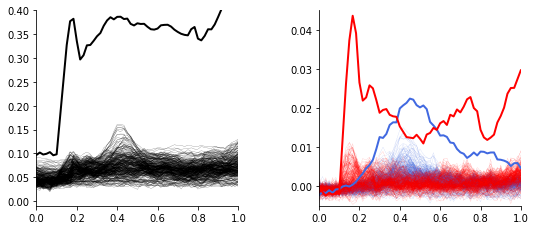

In [57]:
fig, axes = plt.subplots(1, 2, figsize=[8, 3.5], sharex=True)

H, H_r, K_r, times, features = get_results('Forward', 1)
H_r = H_r[:, [1, 0]]
K_r = K_r[:, [1, 0]]
scores = H_r - K_r
for s, c in zip(scores.transpose(1,0,2), ('royalblue', 'red')):
    axes[1].plot(times, s, color=c, linestyle=':', lw=.2)
for s in H_r.transpose(1,0,2):
    axes[0].plot(times, s, color='k', linestyle=':', lw=.2)

axes[1].set_xlim(times[0], times[-1])
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.xlim(0,  1.)
axes[0].set_xticks(np.arange(0, 1.001, .2))
axes[0].set_ylim(-0.01,  .4)
axes[1].set_ylim(-0.005,  .045)
fig.savefig('forward.png', dpi=150)

H, H_r, K_r, times, features = get_results('B2B', 1)
H_r = H_r[:, [1, 0]]
K_r = K_r[:, [1, 0]]
scores = H_r - K_r
for s, c in zip(scores.T, ('royalblue', 'red')):
    axes[1].plot(times, s, color=c, lw=2)
axes[0].plot(times, np.mean(H_r, 1), color='k', lw=2)


if False:
    H, H_r, K_r, times, features = get_results('B2B', 20)
    H_r = H_r[:, [1, 0]]
    K_r = K_r[:, [1, 0]]
    scores = H_r - K_r
    for s, c in zip(scores.T, ('royalblue', 'red')):
        axes[1].plot(times, s, color=c, lw=2)
    axes[0].plot(times, np.mean(H_r, 1), color='k', lw=2)

axes[0].set_ylim(-0.01,  .4)
axes[1].set_ylim(-0.005,  .045)
plt.tight_layout()
fig.savefig('b2b.png', dpi=150)

In [ ]:
0

In [201]:
fig.savefig('rebuttal.pdf')